# HOG + LogRes (Evaluation)

Tested on Google Colab 1.0.0 using Python 3.10.12

In [45]:
!pip list | grep google-colab
!python --version

google-colab                       1.0.0
Python 3.10.12


## Clone and install necessary dataset/library

In [46]:
!git clone https://github.com/ChronoStellar/Automatic-License-Plate-Recognition
!pip install evaluate jiwer

fatal: destination path 'Automatic-License-Plate-Recognition' already exists and is not an empty directory.


In [47]:
# Save the req
!pip freeze > requirements.txt

## Load Dataset

In [48]:
import os
import evaluate
import cv2
from google.colab.patches import cv2_imshow
import joblib
from skimage.feature import hog
import numpy as np

In [49]:
# Process Dataset
PATH = '/content/Automatic-License-Plate-Recognition/dataset/test'
images = []
labels = []

for filename in os.listdir(PATH):
  labels.append(filename[:-4])
  images.append(os.path.join(PATH, filename))

In [50]:
cer = evaluate.load('cer')
wer = evaluate.load('wer')
MODEL_PATH = '/content/Automatic-License-Plate-Recognition/recognizer_model/HOG_LogRes/results/hog_logres_model.pkl'
clf = joblib.load(MODEL_PATH)

## Evaluation

In [51]:
def hog_logres_ocr(PATH):

  im = cv2.imread(PATH)
  # Error handling
  if im is None:
    print(f"Error: Unable to load image {PATH}")
    return

  # Resize
  im = cv2.resize(im, (224, 56))

  # Grayscale
  im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

  # Threshold for the countours
  ret, im_th = cv2.threshold(im_gray, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  # Find the countours
  ctrs, hier = cv2.findContours(im_th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  bboxes = [cv2.boundingRect(c) for c in ctrs]
  sorted_bboxes = sorted(bboxes, key=lambda b: b) # Sort by x-coordinate

  plate_char = []
  image_height, image_width = im.shape[:2]
  height_threshold = image_height * 0.3
  width_threshold = image_width * 0.3

  # For each rectangular region, calculate HOG features and predict
  # the digit using our logistic regression model.
  for num, i_bboxes in enumerate(sorted_bboxes):
    [x, y, w, h] = i_bboxes
    if h > height_threshold and w < width_threshold:
      # Make the rectangular region around the digit
      cv2.rectangle(im, (x, y), (x + w, y + h), (255, 255, 0), 1)
      roi = im_gray[y:y + h, x:x + w]

      # Resize the image
      roi = cv2.resize(roi, (32, 32), interpolation=cv2.INTER_AREA)

      # Calculate the HOG features
      # use the same parameters used for training
      roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(1, 1))
      nbr = clf.predict(np.array([roi_hog_fd]))
      cv2.putText(im, str(nbr[0]), (x + 2, y + h - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
      plate_char.append(str(nbr[0]))

  cv2_imshow(im)
  return ''.join(plate_char)

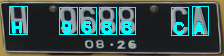

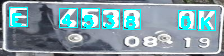

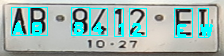

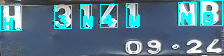

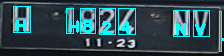

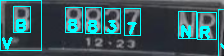

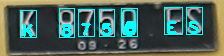

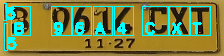

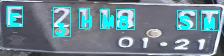

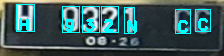

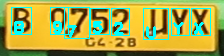

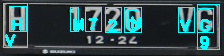

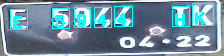

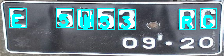

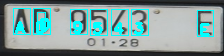

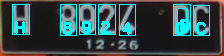

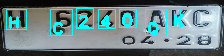

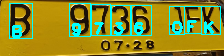

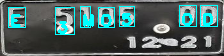

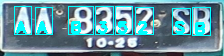

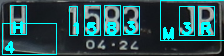

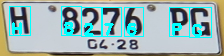

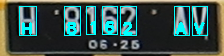

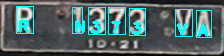

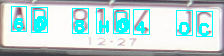

In [52]:
pred = []
for i in range(len(images)):
  pred.append(hog_logres_ocr(images[i]))

In [53]:
word_accuracy = wer.compute(references=labels, predictions=pred)
character_accuracy = cer.compute(references=labels, predictions=pred)

print(f'wer: {word_accuracy}, cer: {character_accuracy}')

wer: 0.84, cer: 0.2677595628415301


In [55]:
print(f'Results (Prediction, True Value):')
for i,x in enumerate(zip(pred, labels)):
  print(i+1,x)

Results (Prediction, True Value):
1 ('H9688CA', 'H9688CA')
2 ('E45380K', 'E4538QK')
3 ('AB8412EW', 'AB8412EI')
4 ('H3N4MNB', 'H3141NB')
5 ('HH824NVT', 'H1824NV')
6 ('VB8837NRY', 'B8837NR')
7 ('K875OBES', 'K8750ES')
8 ('55B96A4CXT', 'B9614CXT')
9 ('E3HM8SM', 'E2118ST')
10 ('H932NCC', 'H9321CC')
11 ('B9752UYX', 'B9752UYX')
12 ('VHM72OHV9G', 'H1720VG')
13 ('E5944HK', 'E5944TK')
14 ('E5UH53RC', 'E5053RG.')
15 ('ADD9543E', 'AD9543E')
16 ('H8924DDC', 'H8924DC')
17 ('HC24OQK', 'H6240AKC')
18 ('B9736OFK', 'B9736JFK')
19 ('E3MO5OD', 'E5105OD')
20 ('AAB352SB', 'AA8352SB')
21 ('4H1583M3R', 'H1583JR')
22 ('H8276PG', 'H8276PG')
23 ('H8162AV', 'H8162AV')
24 ('RN373VA', 'R1373VA')
25 ('6DD8HOO4OC', 'AD8104JC')
